In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import duckdb
import time
import ast
import numpy as np
from scipy.stats import ks_2samp, mannwhitneyu, kendalltau

In [50]:
def get_resume_dataset(industry, exp_level, exp_title_role):
    """
    returns a subset of the original dataset based on industry, experience_level, experience_title_role;
    the additional_exp_level_conditional for loop adds WHERE statements to ignore rows with higher experience_level than specified
        ie., we won't want to compare director level resumes from people who have occupied cxo level positions, even if both director and cxo are there        
    """
    experience_level_hierarchy = ['unpaid', 'training', 'entry', 'senior', 'manager', 'director', 'vp', 'partner', 'cxo', 'owner']
    
    additional_exp_level_conditional = ''
    for i in range(len(experience_level_hierarchy)):
        if experience_level_hierarchy[i] == EXP_LEVEL:
            for j in range(i + 1, len(experience_level_hierarchy)):
                additional_exp_level_conditional += f" AND '{experience_level_hierarchy[j]}' != ALL(temp_exp_list)"

    pdf = duckdb.sql(f"""
        SELECT 
            *,
            list_transform(str_split(EXPERIENCE_LEVEL, ','), x -> lower(trim(x))) AS temp_exp_list
        FROM read_parquet('/scratch/zl3239/dewey_final/final_shortened.parquet')
        WHERE INDUSTRY = '{industry}'
          AND list_contains(list_transform(str_split(EXPERIENCE_LEVEL, ','), x -> lower(trim(x))), lower('{exp_level}'))
          AND list_contains(list_transform(str_split(EXPERIENCE_TITLE_ROLE, ','), x -> lower(trim(x))), lower('{exp_title_role}'))
          AND (SELECT COUNT(DISTINCT x) FROM UNNEST(list_transform(str_split(EXPERIENCE_TITLE_ROLE, ','), x -> lower(trim(x)))) AS t(x)) = 1
          {additional_exp_level_conditional}
    """).to_df()

    pdf = pdf.drop(columns=['temp_exp_list'])
    pdf = pdf.drop(columns=['INDUSTRY', 'EXPERIENCE_LEVEL', 'EXPERIENCE_TITLE_ROLE'])

    print(f'This dataset has {len(pdf)} rows')
    return pdf

def get_batch_from_repository(df, industry, exp_level, exp_title_role, batch_num, batch_info_path='known_batches.csv'):
    """
    logic is too difficult to explain at 4am
    """
    if not os.path.exists(batch_info_path):
        raise Exception('Repository does not exist. Create a batch first.')

    known_batches_df= pd.read_csv(batch_info_path)
    row = known_batches_df[(known_batches_df.INDUSTRY == industry) & (known_batches_df.EXP_LEVEL == exp_level) \
            & (known_batches_df.EXP_TITLE_ROLE == exp_title_role) & (known_batches_df.BATCH_NUM == batch_num)]

    if row.empty:
        raise Exception('No such batch exists. Create a batch instead.')

    person_ids = ast.literal_eval(row.iloc[0].PERSON_IDS)
    return df[df.PERSON_ID.isin(person_ids)]

def get_dataframe_from_folder(folder_path, industry, exp_level, exp_title_role, test_type, batch_num, llm_type):
    industry = re.sub(r'[^a-zA-Z0-9]', '_', industry)
    file_paths = os.listdir(folder_path)
    csv_file_paths = [path for path in file_paths if path.endswith('.csv')]

    for category in [industry, exp_level, exp_title_role, test_type, llm_type]:
        csv_file_paths = [path for path in csv_file_paths if category in path]

    csv_file_paths = [path for path in csv_file_paths if f'batch_{batch_num}' in path]

    if len(csv_file_paths) == 0:
        print('Batch number not found.')
    elif len(csv_file_paths) > 1:
        print(f'Multiple files found: {csv_file_paths}')
    
    return pd.read_csv(folder_path + '/' + csv_file_paths[0], index_col=0)

def data_df_sanity_check(df):
    num_rankings_set = set()
    
    for i in range(len(df)):
        row = df.iloc[i]
        num_rankings = len(ast.literal_eval(row.RANKINGS))
        num_rankings_set.add(num_rankings)
    
    if num_rankings_set != {50,}:
        print(f'Invalid results in batch. Number of rankings != 50: {num_rankings_set}')
    
    return num_rankings_set
    
def get_dataframe_with_ranks(main_df, folder_path, industry, exp_level, exp_title_role, test_type, batch_num, llm_type, batch_info_path):
    """
    with main_df (containing all resumes for specific industry, etc.), get batched resumes ranks (the data we collected) and merges them
    """
    data_df = get_dataframe_from_folder(folder_path, industry, exp_level, exp_title_role, test_type, batch_num, llm_type)
    if data_df_sanity_check(data_df) != {50,}:
        print('Sanity check failed. Invalid dataframe requires repopulating values')

    main_df_batched = get_batch_from_repository(main_df, industry, exp_level, exp_title_role, batch_num, batch_info_path)
    return data_df.merge(main_df_batched, on='PERSON_ID')

def get_dataframe_with_all_ranks(main_df, folder_path, industry, exp_level, exp_title_role, batch_num, llm_type, batch_info_path):
    df_gt_cl = get_dataframe_with_ranks(
        main_df, folder_path, industry, exp_level, exp_title_role,
        'ground truth', batch_num, llm_type, batch_info_path
    )
    df_gt_cl.rename(columns={'RANKINGS': 'GT_RANKINGS'}, inplace=True)
    df_gn_cl = get_dataframe_with_ranks(
        main_df, folder_path, industry, exp_level, exp_title_role,
        'gender null', batch_num, llm_type, batch_info_path
    )
    df_gn_cl.rename(columns={'RANKINGS': 'GN_RANKINGS'}, inplace=True)
    df_gs_cl = get_dataframe_with_ranks(
        main_df, folder_path, industry, exp_level, exp_title_role,
        'gender switched', batch_num, llm_type, batch_info_path
    )
    df_gs_cl.rename(columns={'RANKINGS': 'GS_RANKINGS'}, inplace=True)

    df_gt_cl = df_gt_cl.merge(df_gn_cl, on=[col for col in df_gt_cl.columns if 'RANKINGS' not in col])
    return df_gt_cl.merge(df_gs_cl, on=[col for col in df_gt_cl.columns if 'RANKINGS' not in col])

def get_separate_dataframes_by_gender(df):
    return df[df['SEX'] == 'male'], df[df['SEX'] == 'female']

def get_gendered_statistics(df, target='average'):
    values_gn, values_gs = [], []
    
    for index in range(len(df)):
        row = df.iloc[index]
        gt = ast.literal_eval(row.GT_RANKINGS)
        gn = ast.literal_eval(row.GN_RANKINGS)
        gs = ast.literal_eval(row.GS_RANKINGS)

        if target == 'average':
            values_gn.append(np.average(gn) - np.average(gt))
            values_gs.append(np.average(gs) - np.average(gt))
        elif target == 'std':
            values_gn.append(np.std(gn) - np.std(gt))
            values_gs.append(np.std(gs) - np.std(gt))
        else:
            pass
    
    return values_gn, values_gs

def get_heatmap_matrix(main_df, folder_path, industry, exp_level, exp_title_role, batch_info_path, target='average'):
    llms = ['claude', 'openai']
    genders = ['male', 'female']
    rows = ['GN', 'GS']
    batches = range(1, 6)
    
    heatmap_matrix = {llm: {gender: np.zeros((len(rows), len(batches))) for gender in genders} for llm in llms}
    
    for lt in llms:
        for i, bn in enumerate(batches):
            df = get_dataframe_with_all_ranks(main_df, folder_path, industry, exp_level, exp_title_role, bn, lt, batch_info_path)
            df_male, df_female = get_separate_dataframes_by_gender(df)
    
            male_values_gn, male_values_gs = get_gendered_statistics(df_male, target=target)
            female_values_gn, female_values_gs = get_gendered_statistics(df_female, target=target)
    
            heatmap_matrix[lt]['male'][0, i] = np.nanmean(male_values_gn)
            heatmap_matrix[lt]['male'][1, i] = np.nanmean(male_values_gs)
            
            heatmap_matrix[lt]['female'][0, i] = np.nanmean(female_values_gn)
            heatmap_matrix[lt]['female'][1, i] = np.nanmean(female_values_gs)

    return heatmap_matrix

def show_heatmap_among_batches(heatmap_matrix, title=''):
    llms = ['claude', 'openai']
    genders = ['male', 'female']
    rows = ['GN-GT', 'GS-GT']
    batches = range(1, 6)
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    
    all_data = np.array([heatmap_matrix[llm][gender] for llm in llms for gender in genders])
    vmin, vmax = np.nanmin(all_data), np.nanmax(all_data)
    abs_max = max(abs(vmin), abs(vmax))
    
    for i, llm in enumerate(llms):
        for j, gender in enumerate(genders):
            ax = axes[i, j]
            data = heatmap_matrix[llm][gender]
    
            im = ax.imshow(data, aspect='auto', cmap='RdYlGn_r', vmin=-5, vmax=5)
    
            ax.set_xticks(range(len(batches)))
            ax.set_xticklabels([f'Batch {b}' for b in batches])
            ax.set_yticks(range(len(rows)))
            ax.set_yticklabels(rows)
            ax.set_title(f'{llm.capitalize()} {gender.capitalize()}')
    
            for row_idx in range(data.shape[0]):
                for col_idx in range(data.shape[1]):
                    value = data[row_idx, col_idx]
                    if not np.isnan(value):
                        ax.text(col_idx, row_idx, f'{value:.2f}', ha='center', va='center', color='black')
    
    fig.subplots_adjust(right=0.88, hspace=0.3)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Avg Difference (GN/GS - GT)')
    fig.subplots_adjust(bottom=0.15)
    fig.text(0.56, 0.02, title, ha='center', va='center', fontsize=11, wrap=True)
    plt.show()

def show_heatmap_overall(heatmap_matrix, title=''):
    llms = ['claude', 'openai']
    genders = ['male', 'female']
    rows = ['GN-GT', 'GS-GT']
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    all_data = []
    for llm in llms:
        for gender in genders:
            all_batches = heatmap_matrix[llm][gender]
            all_data.append(all_batches)
    all_data = np.concatenate(all_data, axis=1)
    abs_max = np.nanmax(np.abs(all_data))
    
    for i, llm in enumerate(llms):
        ax = axes[i]
    
        heatmap_data = np.zeros((len(rows), len(genders)))
    
        for j, gender in enumerate(genders):
            data = heatmap_matrix[llm][gender]
            mean_across_batches = np.nanmean(data, axis=1)
            heatmap_data[:, j] = mean_across_batches
    
        im = ax.imshow(heatmap_data, aspect='auto', cmap='RdYlGn_r', vmin=-5, vmax=5)
    
        ax.set_xticks(range(len(genders)))
        ax.set_xticklabels([g.capitalize() for g in genders])
        ax.set_yticks(range(len(rows)))
        ax.set_yticklabels(rows)
        ax.set_title(f'{llm.capitalize()} Average Across Batches')
    
        for row_idx in range(heatmap_data.shape[0]):
            for col_idx in range(heatmap_data.shape[1]):
                value = heatmap_data[row_idx, col_idx]
                if not np.isnan(value):
                    ax.text(col_idx, row_idx, f'{value:.2f}', ha='center', va='center', color='black')
    
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.03, pad=0.04)

    fig.subplots_adjust(right=0.85)

    cbar.set_label('Avg Difference (GN/GS - GT)')
    fig.subplots_adjust(bottom=0.15)
    fig.text(0.56, 0.02, title, ha='center', va='center', fontsize=11, wrap=True)
    plt.show()

In [3]:
FOLDER_PATH = 'rankings_data'
BATCH_INFO_PATH = 'known_batches.csv'
TEST_TYPE = 'ground truth'
BATCH_NUM = 1
LLM_TYPE = 'openai'

In [4]:
INDUSTRY = 'hospital & health care'
EXP_LEVEL = 'entry'
EXP_TITLE_ROLE = 'health'

pdf_hhc = get_resume_dataset(INDUSTRY, EXP_LEVEL, EXP_TITLE_ROLE)

INDUSTRY = 'computer software'
EXP_LEVEL = 'entry'
EXP_TITLE_ROLE = 'engineering'

pdf_cs = get_resume_dataset(INDUSTRY, EXP_LEVEL, EXP_TITLE_ROLE)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

This dataset has 639 rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

This dataset has 6342 rows


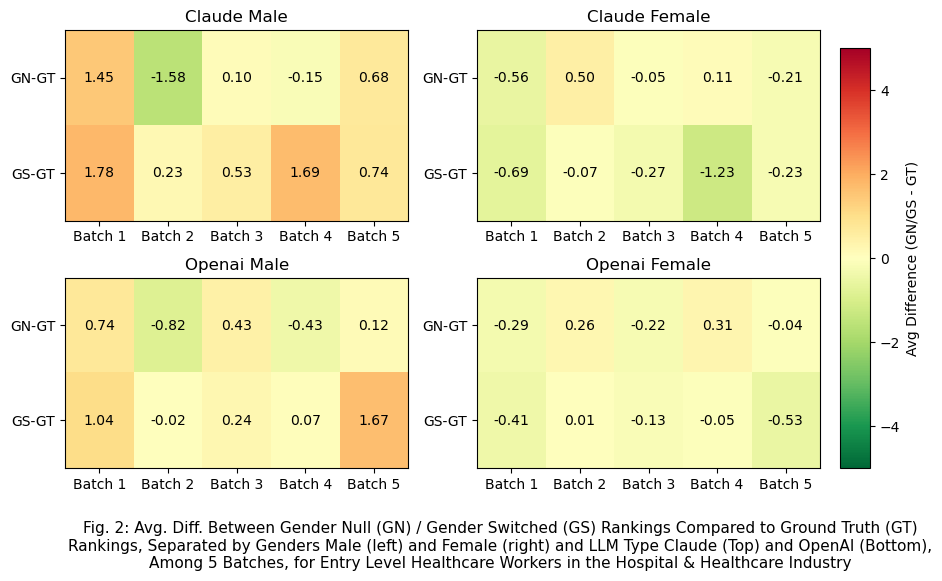

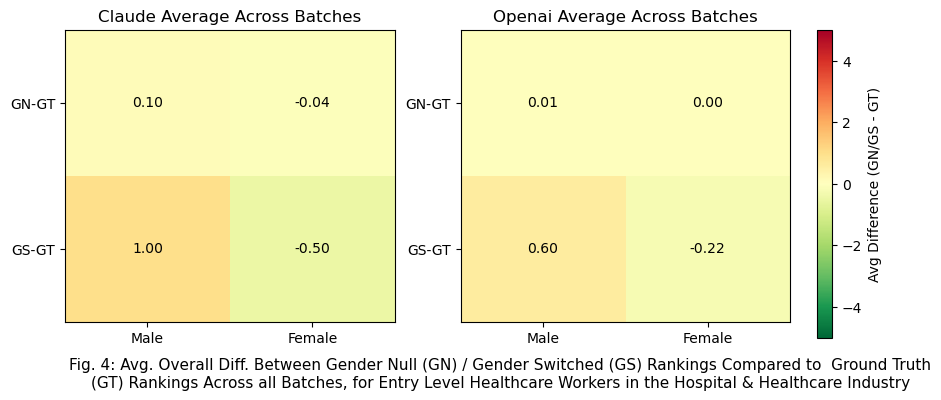

In [51]:
INDUSTRY = 'hospital & health care'
EXP_LEVEL = 'entry'
EXP_TITLE_ROLE = 'health'

heatmap_matrix = get_heatmap_matrix(pdf_hhc, FOLDER_PATH, INDUSTRY, EXP_LEVEL, EXP_TITLE_ROLE, BATCH_INFO_PATH)
show_heatmap_among_batches(heatmap_matrix, title='Fig. 2: Avg. Diff. Between Gender Null (GN) / Gender Switched (GS) Rankings Compared to Ground Truth (GT) Rankings, Separated by Genders Male (left) and Female (right) and LLM Type Claude (Top) and OpenAI (Bottom), Among 5 Batches, for Entry Level Healthcare Workers in the Hospital & Healthcare Industry')
show_heatmap_overall(heatmap_matrix, title='Fig. 4: Avg. Overall Diff. Between Gender Null (GN) / Gender Switched (GS) Rankings Compared to  Ground Truth (GT) Rankings Across all Batches, for Entry Level Healthcare Workers in the Hospital & Healthcare Industry')

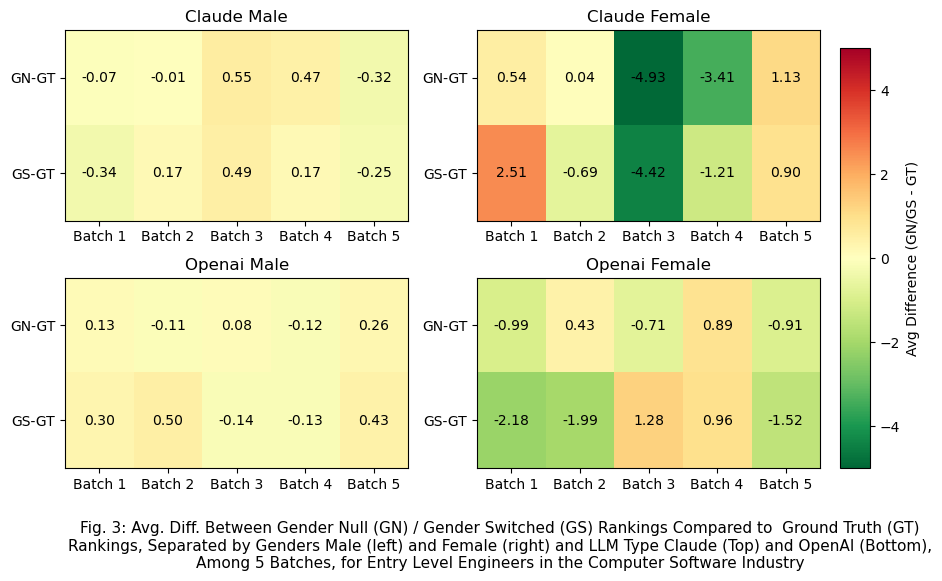

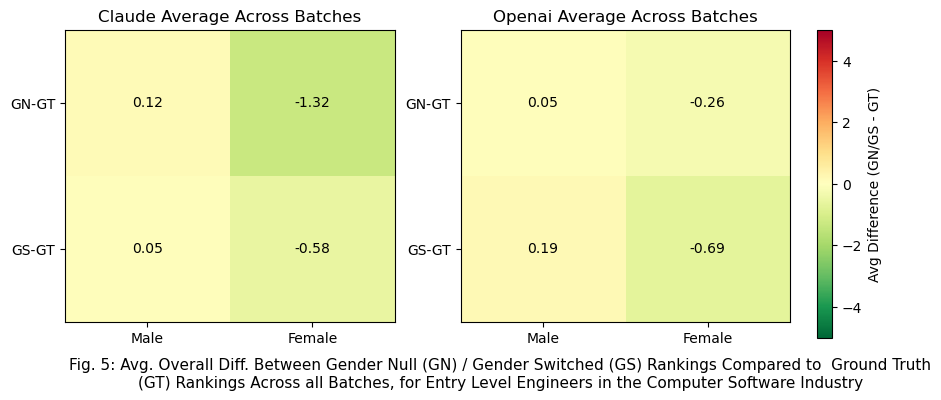

In [52]:
INDUSTRY = 'computer software'
EXP_LEVEL = 'entry'
EXP_TITLE_ROLE = 'engineering'

heatmap_matrix = get_heatmap_matrix(pdf_cs, FOLDER_PATH, INDUSTRY, EXP_LEVEL, EXP_TITLE_ROLE, BATCH_INFO_PATH)
show_heatmap_among_batches(heatmap_matrix, title='Fig. 3: Avg. Diff. Between Gender Null (GN) / Gender Switched (GS) Rankings Compared to  Ground Truth (GT) Rankings, Separated by Genders Male (left) and Female (right) and LLM Type Claude (Top) and OpenAI (Bottom), Among 5 Batches, for Entry Level Engineers in the Computer Software Industry')
show_heatmap_overall(heatmap_matrix, title='Fig. 5: Avg. Overall Diff. Between Gender Null (GN) / Gender Switched (GS) Rankings Compared to  Ground Truth (GT) Rankings Across all Batches, for Entry Level Engineers in the Computer Software Industry')